In [1]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor
from qiime2.plugins.empress.actions import community_plot

from assets.step_wise_anova import run_stepwise_anova

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re

import statsmodels
from scipy.stats import mannwhitneyu
from itertools import combinations
from matplotlib.colors import LogNorm, Normalize

# Importing files (3DMM)

In [2]:
gg2_ft = Artifact.load('./data/katharo_deblur_gg2_feature_table.qza')

In [3]:
gg2_taxonomy = Artifact.load('./data/gg2_taxonomy.qza')

In [4]:
gg2_taxonomy_df = gg2_taxonomy.view(pd.DataFrame)

In [5]:
gg2_tree = Artifact.load('./data/2022.10.phylogeny.asv.nwk.qza')

In [6]:
##Updated. Need to update metadata in Qiita study
metadata = Metadata.load('./metadata/2023_03_21_3DMM_metadata_to_update_qiita.txt')

In [7]:
# feature_metadata = Metadata.load('./metadata/taxonomy.tsv')
gg2_feature_metadata = Metadata.load('./metadata/gg2_taxonomy.tsv')

In [8]:
metadata_df = metadata.to_dataframe()

# Meta-analysis (w_Daniel)

In [9]:
meta_ft = Artifact.load('./data/16S_feature-table-with-10689.gg2-2022.10.min1000.biom.qza')
meta_phyloRPCA_bp = Artifact.load('./data/phyloRPCA-with-10689/biplot.qza')
meta_phyloRPCA_tax = Artifact.load('./data/phyloRPCA-with-10689/t2t_taxonomy.qza')
meta_phyloRPCA_cbn = Artifact.load('./data/phyloRPCA-with-10689/counts_by_node.qza')
meta_phyloRPCA_cbnt = Artifact.load('./data/phyloRPCA-with-10689/counts_by_node_tree.qza')
meta_phyloRPCA_dm = Artifact.load('./data/phyloRPCA-with-10689/distance_matrix.qza')

In [10]:
meta_metadata = Metadata.load('./metadata/multy_study_metadata_merged_with_10689.tsv')
meta_metadata_df = meta_metadata.to_dataframe()

In [11]:
meta_metadata_df['qiita_study_id'].nunique()

16

In [12]:
meta_metadata_df['date'] = pd.to_datetime(meta_metadata_df['date'],infer_datetime_format=True,errors='coerce')

In [13]:
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==13114)&
                    (meta_metadata_df['qiita_empo_1']=='Free-living'),'test_column']='EMP: Free-living'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==13114)&
                    (meta_metadata_df['qiita_empo_1']=='Host-associated'),'test_column']='EMP: Host-associated'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==13114)]['test_column'].value_counts()

EMP: Free-living        453
EMP: Host-associated    428
Name: test_column, dtype: int64

In [14]:
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==14898),'test_column']='ISS: MT-1'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==14898)]['test_column'].value_counts()

ISS: MT-1    52
Name: test_column, dtype: int64

In [15]:
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==14897)&
                    (meta_metadata_df['cohort']=='lukas1'),'test_column']='Home: rural (LUKAS1)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==14897)&
                    (meta_metadata_df['cohort']=='lukas2'),'test_column']='Home: suburban (LUKAS2)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==14897)]['test_column'].value_counts()

Home: rural (LUKAS1)       401
Home: suburban (LUKAS2)    375
Name: test_column, dtype: int64

In [16]:
study_id = 14542
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']='ISS: 3DMM'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

ISS: 3DMM    803
Name: test_column, dtype: int64

In [17]:
study_id = 13957
rename_string = 'Isolation Dorms: COVID-19'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Isolation Dorms: COVID-19    409
Name: test_column, dtype: int64

In [18]:
study_id = 13092
rename_string = 'Hospital: COVID-19'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Hospital: COVID-19    1135
Name: test_column, dtype: int64

In [19]:
study_id = 12858
rename_string = 'Closed-habitat: HI-SEAS'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Closed-habitat: HI-SEAS    104
Name: test_column, dtype: int64

In [20]:
study_id = 11950
rename_string = 'Indoor Materials'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Indoor Materials    555
Name: test_column, dtype: int64

In [21]:
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==11865)&
                    (meta_metadata_df['timepoint']=='t1'),'test_column']='Home: Pre-occupation (HOMEChem)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==11865)&
                    (meta_metadata_df['timepoint']=='t2'),'test_column']='Home: Post-occupation (HOMEChem)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==11865)]['test_column'].value_counts()

Home: Pre-occupation (HOMEChem)     271
Home: Post-occupation (HOMEChem)    271
Name: test_column, dtype: int64

In [22]:
study_id = 10850
rename_string = 'Closed-habitat: NEEMO'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Closed-habitat: NEEMO    32
Name: test_column, dtype: int64

In [23]:
study_id = 10423
rename_string = 'Office: geographical gradient'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Office: geographical gradient    4625
Name: test_column, dtype: int64

In [24]:
study_id = 10244
rename_string = 'Office: 3D map'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Office: 3D map    150
Name: test_column, dtype: int64

In [25]:
study_id = 2192
rename_string = 'Home: longitudinal'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Home: longitudinal    690
Name: test_column, dtype: int64

In [26]:
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10333)&
                    (meta_metadata_df['village']=='checherta'),'test_column']='Home: Checherta (Jungle)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10333)&
                    (meta_metadata_df['village']=='iquitos'),'test_column']='Home: Iquitos (Town)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10333)&
                    (meta_metadata_df['village']=='manaus'),'test_column']='Home: P. Almendras (Rural)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10333)&
                    (meta_metadata_df['village']=='puerto almendras'),'test_column']='Home: Manaus (Urban)'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10333)]['test_column'].value_counts()

Home: P. Almendras (Rural)    384
Home: Iquitos (Town)          140
Home: Checherta (Jungle)      106
Home: Manaus (Urban)          105
Name: test_column, dtype: int64

In [27]:
start_date = '2/23/13'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10172)&
                     (meta_metadata_df['date']<pd.to_datetime(start_date,infer_datetime_format=True)),
                     'test_column']='Hospital: Pre-occupation'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10172)&
                     (meta_metadata_df['date']>pd.to_datetime(start_date,infer_datetime_format=True)),
                     'test_column']='Hospital: Post-occupation'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==10172)]['test_column'].value_counts()

Hospital: Post-occupation    3780
Hospital: Pre-occupation      583
Name: test_column, dtype: int64

In [28]:
study_id = 10689
rename_string = 'Spacecraft Assembly Facility'
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id),'test_column']=rename_string
meta_metadata_df.loc[(meta_metadata_df['qiita_study_id']==study_id)]['test_column'].value_counts()

Spacecraft Assembly Facility    100
Name: test_column, dtype: int64

In [29]:
meta_metadata_df.to_csv('./metadata/meta_analysis_metadata_w10689.tsv',sep='\t')

In [30]:
meta_metadata_df.index.names=['#SampleID']

meta_sinks= meta_metadata_df[['test_column']].rename(columns={'test_column':'Env'})

meta_sinks['SourceSink']='sink'

In [31]:
st2_metadata = Metadata.load('./metadata/sourcetracker_metadata.tsv')

In [32]:
st2_metadata_df = st2_metadata.to_dataframe()
sources_df = st2_metadata_df.loc[st2_metadata_df['SourceSink']=='source']

In [33]:
sources_df = sources_df.loc[sources_df['Env']!='building materials']

In [34]:
meta_st = pd.concat([sources_df,meta_sinks])

In [35]:
meta_phyloRPCA_tax = meta_phyloRPCA_tax.view(Metadata).to_dataframe()
meta_phyloRPCA_tax.index.name = 'featureid'
meta_phyloRPCA_feature_loadings = meta_phyloRPCA_bp.view(OrdinationResults).features.rename({0:'PC1',
                                                                                             1:"PC2",
                                                                                             2:"PC3",
#                                                                                                                          3:'PC4',
#                                                                                                                          4:'PC5',
#                                                                                                                          5:'PC6',
#                                                                                                                          6:'PC7',
#                                                                                                                          7:'PC8',
#                                                                                                                          8:'PC9',
#                                                                                                                          9:'PC10'
                                                                                                                        },
                                                                                                axis=1)
meta_phyloRPCA_taxonomy_and_loadings = pd.concat([meta_phyloRPCA_tax,
                                                 meta_phyloRPCA_feature_loadings], axis=1)
meta_phyloRPCA_taxonomy_and_loadings.index.name = 'featureid'
meta_phyloRPCA_taxonomy_and_loadings.head(5)

,Taxon,PC1,PC2,PC3
featureid,,,,
n75020,d__; p__; c__; o__; f__; g__; s__,0.000146,0.000026,-0.000082
n75018,d__Bacteria; p__; c__; o__; f__; g__; s__,0.004263,0.006815,-0.125986
n74314,d__Bacteria; p__; c__; o__; f__; g__; s__,0.005968,0.005089,-0.094388
n74306,d__Bacteria; p__Patescibacteria; c__; o__; f__...,0.004958,0.001555,-0.001471
n616,d__Bacteria; p__Patescibacteria; c__; o__; f__...,0.000456,-0.000220,0.000446


In [36]:
#Printing features driving segregation along PC2
#Most negative features for PC2 (inner tree nodes), and their associated taxonomy
list(meta_phyloRPCA_taxonomy_and_loadings.sort_values(by='PC2').head(30)['Taxon'])

['d__Bacteria; p__Bdellovibrionota_E; c__; o__; f__; g__; s__',
 'd__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Mycobacteriales; f__Mycobacteriaceae; g__Mycobacterium; s__',
 'd__Bacteria; p__; c__; o__; f__; g__; s__',
 'd__Bacteria; p__Bdellovibrionota_E; c__Bdellovibrionia_A_473294; o__Bdellovibrionales; f__; g__; s__',
 'd__Bacteria; p__Bdellovibrionota_E; c__Bdellovibrionia_A_473294; o__Bdellovibrionales; f__; g__; s__',
 'd__Bacteria; p__Bdellovibrionota_E; c__Bdellovibrionia_A_473294; o__Bdellovibrionales; f__; g__; s__',
 'd__Bacteria; p__Chloroflexota; c__; o__; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Chitinophagaceae_966727; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Cyclobacteriaceae_900466; g__; s__',
 'd__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides_A_392796; s__Nocardioides_A_392796 maradonensis',
 'd__Bacteria; p__Pro

In [37]:
#Most positive features for PC2 (inner tree nodes), and their associated taxonomy
list(meta_phyloRPCA_taxonomy_and_loadings.sort_values(by='PC2').tail(20)['Taxon'])

['d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Propionibacteriales; f__Nocardioidaceae; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Prevotella; s__Prevotella melaninogenica',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__; g__; s__',
 'd__Bacteria; p__Firmicutes_A; c__Clostridia_258483; o__Peptostreptococcales; f__Anaerovoracaceae; g__; s__',
 'd__Bacteria; p__Acidobacteriota; c__Blastocatellia; o__; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__; g__; s__',
 'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Bacteroi

In [38]:
#Merging ordination results with metadata for plotting
meta_phyloRPCA_ord = meta_phyloRPCA_bp.view(OrdinationResults).samples[[0,1,2]].merge(meta_metadata_df,left_index=True,
                                                                    right_index=True,how='left')

In [39]:
for group in meta_phyloRPCA_ord['title'].unique():
    for pc in [0,1,2]:
        median = meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['title']==group,pc].median()
        meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['title']==group,str(str(pc)+'_median_title')]=median
for group in meta_phyloRPCA_ord['test_column'].unique():
    for pc in [0,1,2]:
        median = meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group,pc].median()
        meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group,str(str(pc)+'_median')]=median

In [40]:
palette_tab20 = sns.color_palette("tab20", 20)
palette_tab20b = sns.color_palette("tab20b", 20)
meta_phyloRPCA_ord['sizes_plot']=1
meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']=='ISS: 3DMM','sizes_plot']=5
meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']=='ISS: MT-1','sizes_plot']=5
                       
meta_colors= {'ISS: 3DMM':'red',
              'ISS: MT-1':'blue',
               'EMP: Host-associated':'plum',
               'EMP: Free-living':'tab:green',
             'Home: Pre-occupation (HOMEChem)':palette_tab20[17],
             'Home: Post-occupation (HOMEChem)':palette_tab20[16],
              'Hospital: Pre-occupation':palette_tab20[15],
             'Hospital: Post-occupation':palette_tab20[14],
              'Home: rural (LUKAS1)':palette_tab20[9],
              'Home: suburban (LUKAS2)':palette_tab20[8],
              'Home: Manaus (Urban)':palette_tab20b[12],
              'Home: Iquitos (Town)':palette_tab20b[13],
              'Home: P. Almendras (Rural)':palette_tab20b[14],
              'Home: Checherta (Jungle)':palette_tab20b[15],
              'Closed-habitat: NEEMO':'tab:orange',
              'Closed-habitat: HI-SEAS':palette_tab20[11],
              'Indoor Materials':'rosybrown',
              'Office: geographical gradient':'olive',
              'Isolation Dorms: COVID-19':'palegreen',
              'Hospital: COVID-19':'skyblue',
              'Home: longitudinal':palette_tab20[10],
              'Office: 3D map':'gold',
              'Spacecraft Assembly Facility':'lawngreen'
             }

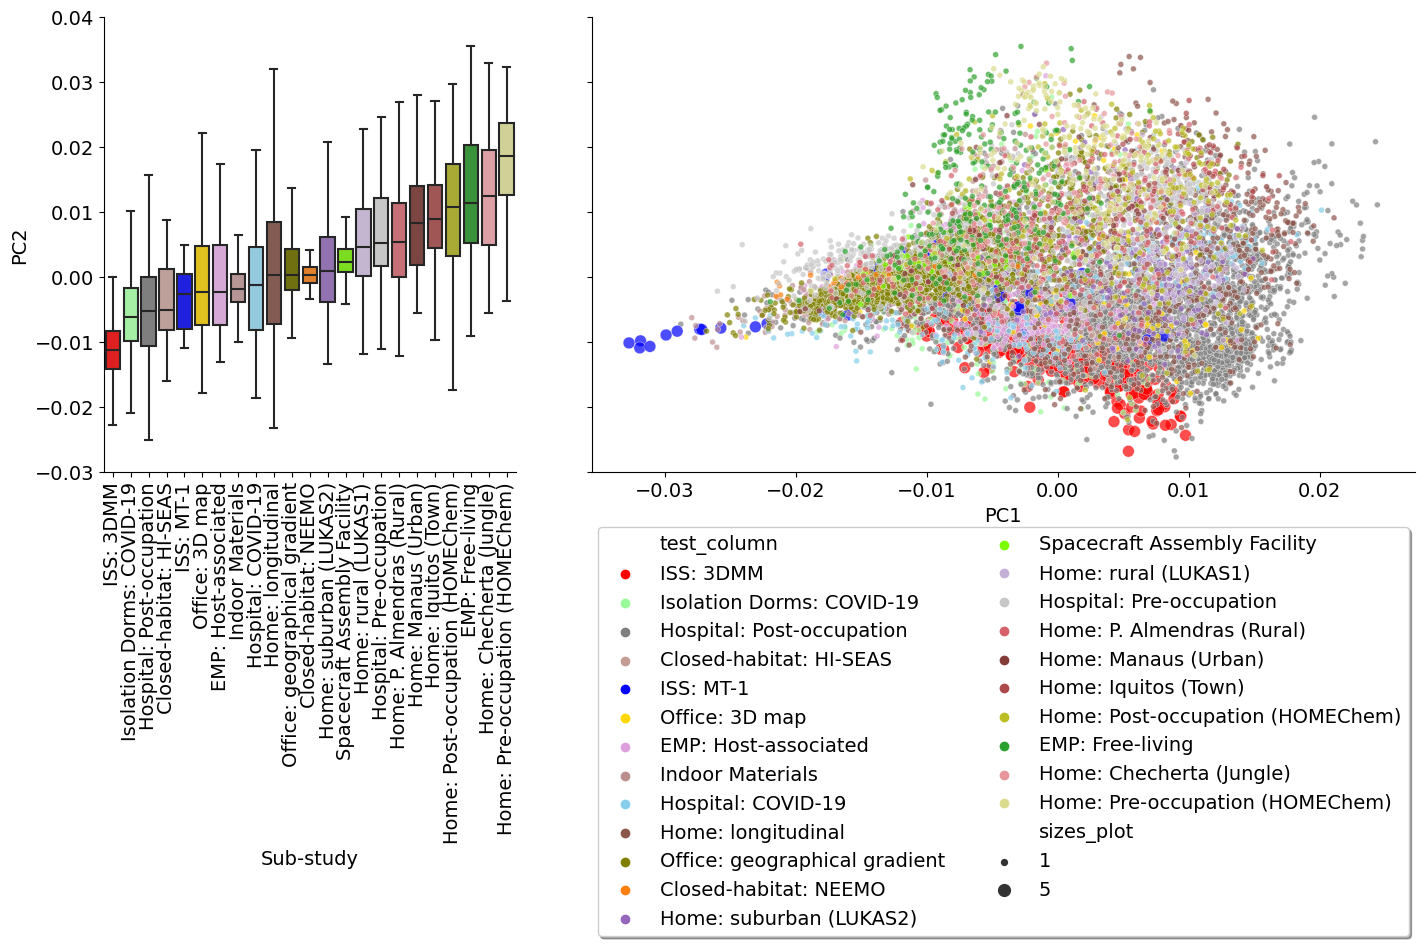

In [41]:
plt.rcParams.update({'font.size': 14})
f, (ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(15,10),gridspec_kw={'width_ratios': [1, 2]},sharey=True)
sns.scatterplot(x=0,y=1,hue='test_column',data=meta_phyloRPCA_ord.sort_values(by='1_median'),
                ax=ax2,palette=meta_colors,size='sizes_plot',alpha=0.7)
#PC2 captures an urbanization gradient effect. This is our PC of interest. 
sns.boxplot(x='test_column',y=1,data=meta_phyloRPCA_ord.sort_values(by='1_median'),fliersize=0,ax=ax1,palette=meta_colors)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylabel('PC2')
ax1.set_xlabel('Sub-study')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
ax2.set_xlabel('PC1')
ax1.set_ylim([-0.03,0.04])
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [42]:
from qiime2.plugins.empress.actions import community_plot

In [43]:
meta_phyloRPCA_taxonomy_and_loadings.shape

(75021, 4)

In [44]:
meta_metadata_df_formatted = meta_metadata_df.copy()
meta_metadata_df_formatted['date'] = meta_metadata_df_formatted['date'].astype(str)

In [45]:
tree_biplot = community_plot(meta_phyloRPCA_cbnt,
                             meta_ft,
                             Metadata(meta_metadata_df_formatted),
                             meta_phyloRPCA_bp,
                             feature_metadata = Metadata(meta_phyloRPCA_taxonomy_and_loadings),
                             number_of_features=100,
                             ignore_missing_samples=False,
                             filter_extra_samples=False,
                             filter_missing_features=True)
tree_biplot.visualization.save('./output/meta_phylo_rpca_empress_gg2.qzv')

'./output/meta_phylo_rpca_empress_gg2.qzv'

In [46]:
#Empress visualization file used to generate trees for figures S6A,S6C,and S6D

# Muli-study analysis statistics

In [47]:
results = []
for group_1, group_2 in combinations(meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),2):
    group_1_PC2_ = meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group_1,1]
    group_2_PC2_ = meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group_2,1]
    u_, p_ = mannwhitneyu(group_1_PC2_,
                 group_2_PC2_)
    results.append([group_1,group_2,u_,p_])
results_df = pd.DataFrame(results,columns=['g1','g2','u','p'])

In [48]:
#FDR correction
sig, corrected_p, _, _ = statsmodels.stats.multitest.multipletests(results_df['p'],method='fdr_bh')
results_df['corrected_p'] = corrected_p
results_df['sig'] = sig

In [49]:
corrected_p_matrix = pd.DataFrame(index=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),
                                 columns=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique())
annot_matrix = corrected_p_matrix.copy()
U_matrix = pd.DataFrame(index=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),
                                 columns=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique())
for group_1, group_2 in combinations(meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),2):
    corrected_p = results_df.loc[(results_df['g1']==group_1)&
                                 (results_df['g2']==group_2),
                                'corrected_p']
    u_ = results_df.loc[(results_df['g1']==group_1)&
                                 (results_df['g2']==group_2),
                                'u']
    sig_ = results_df.loc[(results_df['g1']==group_1)&
                                 (results_df['g2']==group_2),
                                'sig'].values[0]
    corrected_p_matrix.loc[group_1,group_2]=float(corrected_p)
    U_matrix.loc[group_1,group_2]=float(u_)
    annot_matrix.loc[group_1,group_2]=sig_

In [50]:
annot_matrix = annot_matrix.replace(False,'n.s.').replace(True,' ')

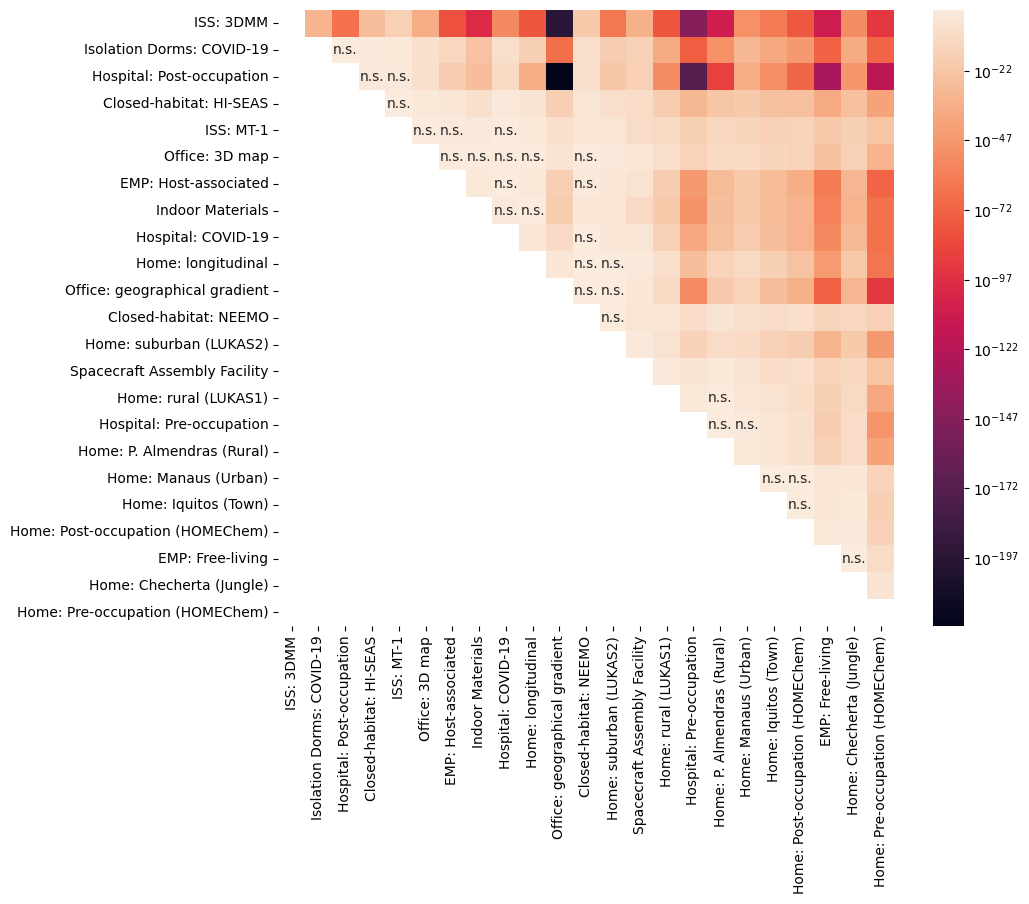

In [51]:
plt.rcParams.update({'font.size': 10})
fig = plt.subplots(figsize=(10,8))
sns.heatmap(corrected_p_matrix.fillna(0),norm=LogNorm(),annot=annot_matrix,fmt = '',square=True)
plt.savefig('./figs/PC2_stats.svg')

In [52]:
# ran on slurm
# #!/bin/bash
# #SBATCH -J PERMANOVA
# #SBATCH --nodes=1
# #SBATCH --ntasks-per-node=4
# #SBATCH --mail-type=end
# #SBATCH --mail-user=rsalidob@ucsd.edu
# #SBATCH --time=0-12:00:00
# #SBATCH --mem-per-cpu=8GB
# #SBATCH --partition=short

# source activate qiime2-2022.11

# qiime diversity beta-group-significance \
# --i-distance-matrix ./data/phylo_rpca_distance_matrix.qza \
# --m-metadata-file ./metadata/2023_01_19_3DMM_metadata_from_qita_updated.txt \
# --m-metadata-column module \
# --p-method permanova \
# --p-pairwise \
# --p-permutations 1000000 \
# --o-visualization ./output/module_permanova_viz.qzv

#used module_permanova_viz.qzv to generate permanova-pairwise_w10689_MP.csv

In [53]:
permanova_df = pd.read_csv('./data/permanova-pairwise_w10689_MP.csv')

In [54]:
alpha_ = 0.01
permanova_df['sig'] = permanova_df['q-value']<alpha_

In [55]:
permanova_q_matrix = pd.DataFrame(index=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),
                                 columns=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique())
permanova_annot_matrix = permanova_q_matrix.copy()
f_matrix = pd.DataFrame(index=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),
                                 columns=meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique())
for group_1, group_2 in combinations(meta_phyloRPCA_ord.sort_values(by='1_median')['test_column'].unique(),2):
    corrected_p = permanova_df.loc[((permanova_df['Group 1']==group_1)&
                                 (permanova_df['Group 2']==group_2))|
                                   ((permanova_df['Group 1']==group_2)&
                                 (permanova_df['Group 2']==group_1)),
                                'q-value']
    f_ = permanova_df.loc[((permanova_df['Group 1']==group_1)&
                                 (permanova_df['Group 2']==group_2))|
                                   ((permanova_df['Group 1']==group_2)&
                                 (permanova_df['Group 2']==group_1)),
                                'pseudo-F']
    sig_ = permanova_df.loc[((permanova_df['Group 1']==group_1)&
                                 (permanova_df['Group 2']==group_2))|
                                   ((permanova_df['Group 1']==group_2)&
                                 (permanova_df['Group 2']==group_1)),
                                'sig'].values[0]
    permanova_q_matrix.loc[group_1,group_2]=float(corrected_p)
    f_matrix.loc[group_1,group_2]=float(f_)
    permanova_annot_matrix.loc[group_1,group_2]=sig_

In [56]:
permanova_annot_matrix = permanova_annot_matrix.replace(False,'n.s.').replace(True,' ')

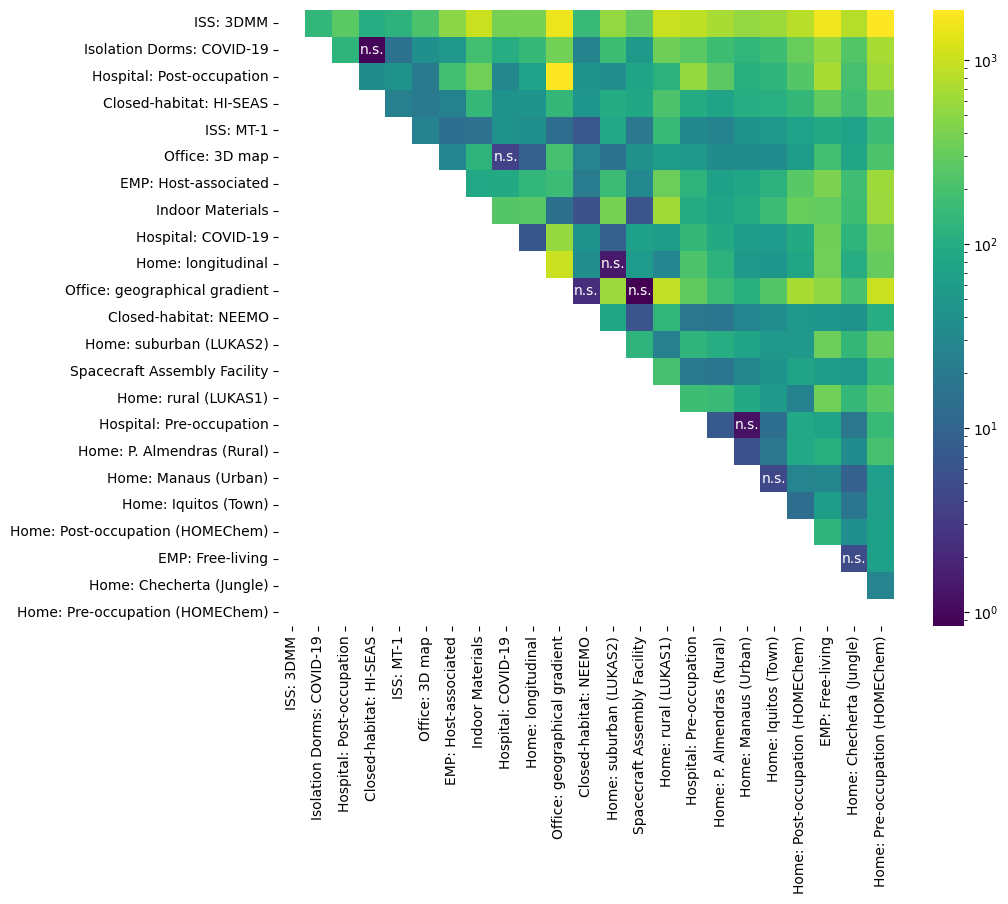

In [57]:
fig = plt.subplots(figsize=(10,8))
sns.heatmap(f_matrix.fillna(0),norm=LogNorm(),annot=permanova_annot_matrix,
            fmt = '',cmap="viridis",square=True)
plt.savefig('./figs/permanova_stats.svg')

# Log-ratio along PC2

In [58]:
meta_phyloRPCA_tax.index.names = ['Feature ID']

In [59]:
meta_phyloRPCA_tax = Artifact.import_data('FeatureData[Taxonomy]',
                                          meta_phyloRPCA_tax)

In [60]:
collapsed_ft = taxa.methods.collapse(meta_ft,meta_phyloRPCA_tax,5).collapsed_table
collapsed_ft = collapsed_ft.view(pd.DataFrame)

In [61]:
families_of_interest = [
    "f__Chitinophagaceae",
    "f__Paenibacillaceae",
    "f__Burkholderiaceae_A",
]

In [62]:
WINDOW_SIZE = 0.00125
mode = "average"  # Can be set to "average" or "median"

sorted_nodes = meta_phyloRPCA_ord[meta_phyloRPCA_ord['env_package'] == 'built environment'].sort_values(by=1)

all_rolling_statistics = []
all_midpoints = []

for family in families_of_interest:
    rolling_statistics = []
    midpoints = []
    print(f"Now computing {family}")
    
    family_values = []
    non_family_values = []
    lower_bound = None
    upper_bound = None

    for node, row in sorted_nodes.iterrows():
        if upper_bound is not None and row[1] > upper_bound:
            if non_family_values:  # Check if list is not empty to avoid errors
                if mode == "average":
                    stat_value = np.log((sum(family_values) + 1) / (sum(non_family_values) + 1))
                elif mode == "median":
                    stat_value = np.log((np.median(family_values) + 1) / (np.median(non_family_values) + 1))
                rolling_statistics.append(stat_value)
                midpoints.append((lower_bound + upper_bound) / 2)
            
            family_values = []
            non_family_values = []
            lower_bound = None
            upper_bound = None

        if upper_bound is None:
            lower_bound = (row[1] // WINDOW_SIZE) * WINDOW_SIZE
            upper_bound = lower_bound + WINDOW_SIZE

        for feature, ft_row in collapsed_ft.loc[node].items():
            if family in str(feature):
                family_values.append(ft_row)
            elif "f__Staphylococcaceae" in str(feature):
                non_family_values.append(ft_row)

    if non_family_values:  # Handle the last window
        if mode == "average":
            stat_value = np.log((sum(family_values) + 1) / (sum(non_family_values) + 1))
        elif mode == "median":
            stat_value = np.log((np.median(family_values) + 1) / (np.median(non_family_values) + 1))
        rolling_statistics.append(stat_value)
        midpoints.append((lower_bound + upper_bound) / 2)

    all_rolling_statistics.append(rolling_statistics)
    all_midpoints.append(midpoints)

Now computing f__Chitinophagaceae
Now computing f__Paenibacillaceae
Now computing f__Burkholderiaceae_A


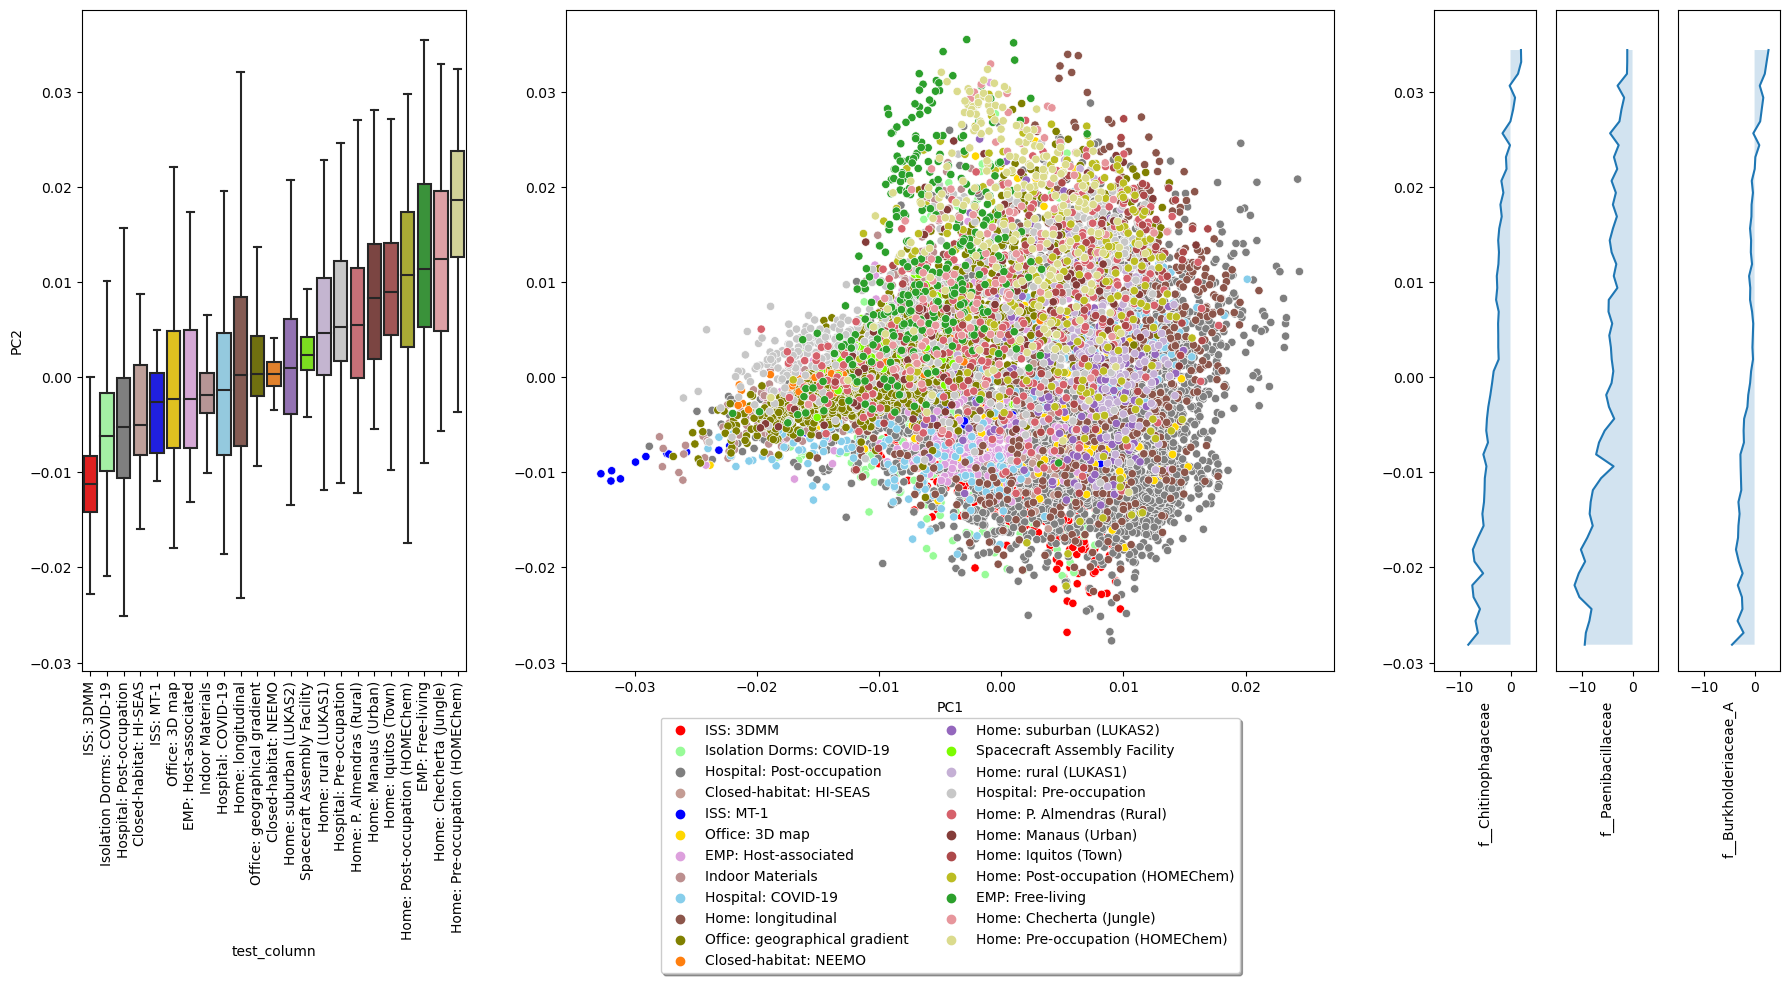

In [63]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# number of abundance plots
num_abundance_plots = len(all_rolling_statistics)

# create a grid of subplots with custom width ratios
width_ratios = [1, 2] + [1] * num_abundance_plots # tweak these width ratios to change aspect ratio
fig = plt.figure(figsize=(15 + (num_abundance_plots * 1), 10))

# define the overall grid
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.3 * len(all_rolling_statistics)])

# define the region for the line plots
line_plots_gs = gridspec.GridSpecFromSubplotSpec(1, len(all_rolling_statistics), subplot_spec=gs[0, 2], wspace=0.2)


# boxplot
ax1 = plt.subplot(gs[0, 0])
sns.boxplot(x='test_column', y=1, data=meta_phyloRPCA_ord.sort_values(by='1_median'),
            fliersize=0, ax=ax1,palette=meta_colors)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylabel('PC2')

# scatterplot
ax2 = plt.subplot(gs[0, 1])
sns.scatterplot(x=0, y=1, hue='test_column', data=meta_phyloRPCA_ord.sort_values(by='1_median'),
                ax=ax2,palette=meta_colors)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, shadow=True, ncol=2)
ax2.set_xlabel('PC1')
ax2.set_ylabel('')
ylim = ax2.get_ylim()

# lineplots
for i, (averaged_abundances, midpoints, family) in enumerate(zip(all_rolling_statistics, all_midpoints, families_of_interest)):
    ax = plt.subplot(line_plots_gs[0, i])
    ax.plot(averaged_abundances, midpoints)
    ax.fill_betweenx(midpoints, averaged_abundances, alpha=0.2)  # Fill the area to the left of the curve
    if i > 0:
        ax.yaxis.set_visible(False)  # Hide y-axis for subsequent line plots
    ax.set_ylim(ylim)
    ax.set_xlim(-15,5)
    ax.set_xlabel(family, rotation=90)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the space between the subplots

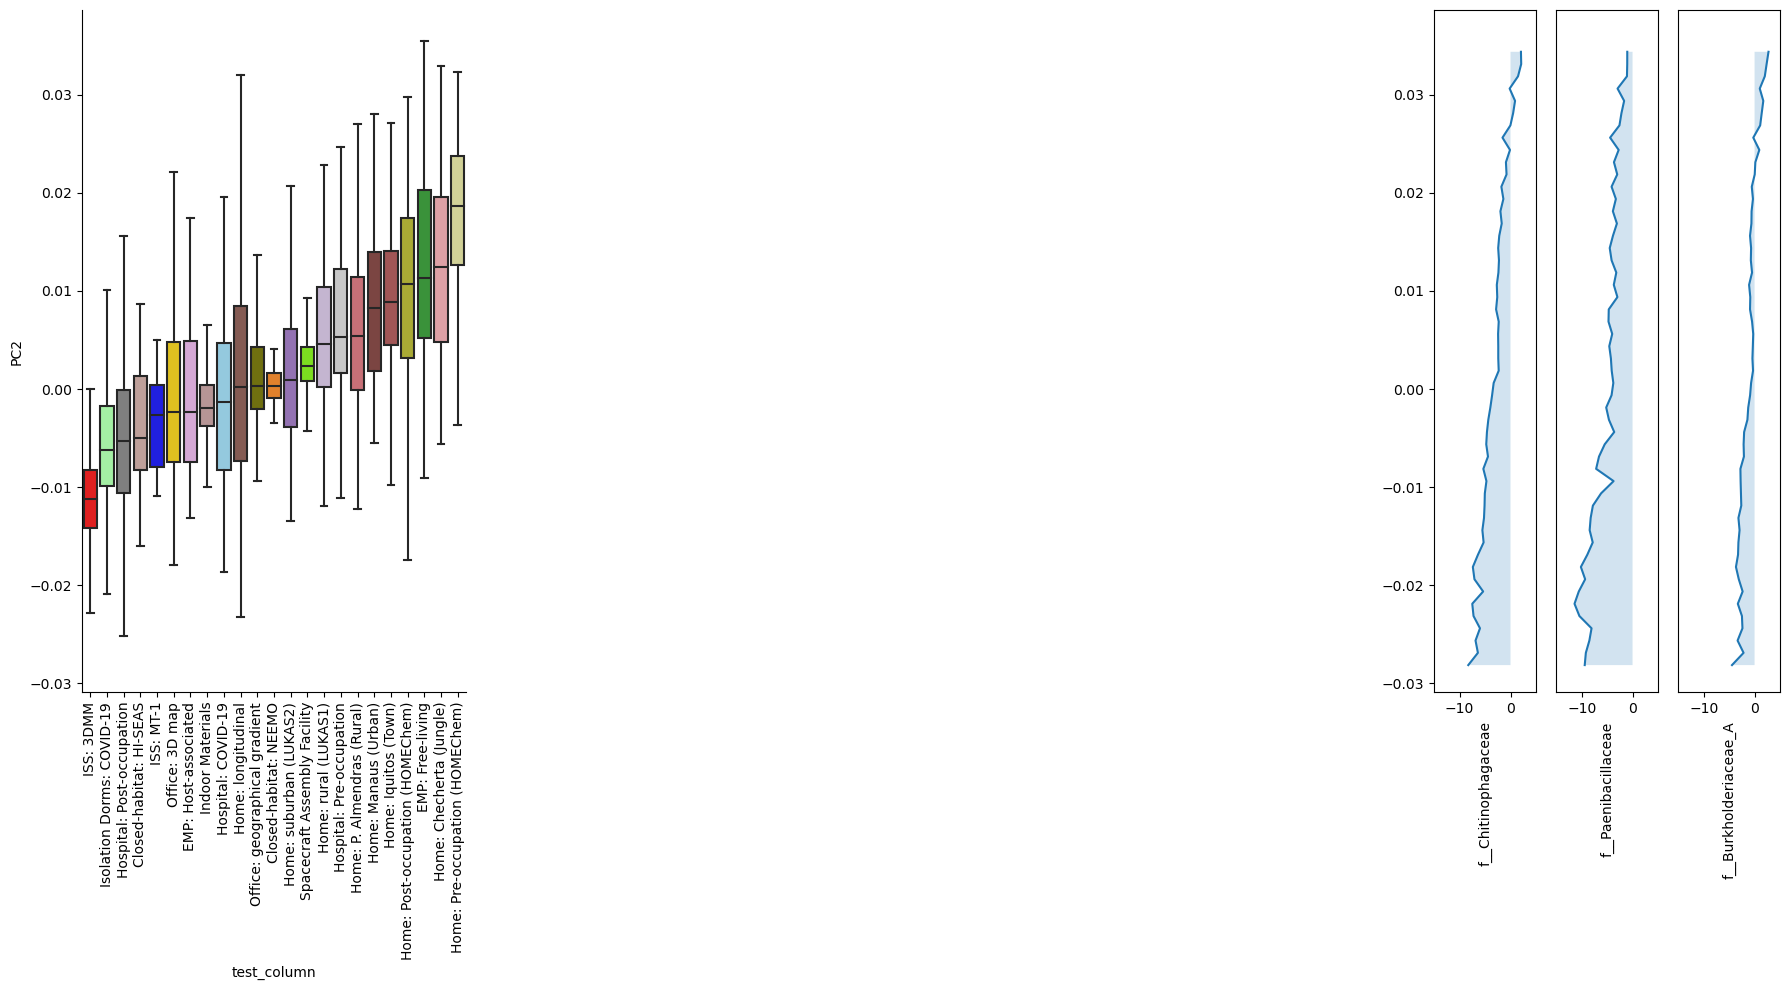

In [64]:
# Fig 5A, right panel
# Fig 5A was arranged with Illustrator for final figure.
# number of abundance plots
num_abundance_plots = len(all_rolling_statistics)

# create a grid of subplots with custom width ratios
width_ratios = [1, 2] + [1] * num_abundance_plots # tweak these width ratios to change aspect ratio
fig = plt.figure(figsize=(15 + (num_abundance_plots * 1), 10))

# define the overall grid
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.3 * len(all_rolling_statistics)])

# define the region for the line plots
line_plots_gs = gridspec.GridSpecFromSubplotSpec(1, len(all_rolling_statistics), subplot_spec=gs[0, 2], wspace=0.2)


# boxplot
ax1 = plt.subplot(gs[0, 0])
sns.boxplot(x='test_column', y=1, data=meta_phyloRPCA_ord.sort_values(by='1_median'), fliersize=0, ax=ax1,
           palette=meta_colors)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylabel('PC2')
ax1.spines[['right', 'top']].set_visible(False)

# lineplots
for i, (averaged_abundances, midpoints, family) in enumerate(zip(all_rolling_statistics, all_midpoints, families_of_interest)):
    ax = plt.subplot(line_plots_gs[0, i])
    ax.plot(averaged_abundances, midpoints)
    ax.fill_betweenx(midpoints, averaged_abundances, alpha=0.2)  # Fill the area to the left of the curve
    if i > 0:
        ax.yaxis.set_visible(False)  # Hide y-axis for subsequent line plots
    ax.set_ylim(ylim)
    ax.set_xlim(-15,5)
    ax.set_xlabel(family, rotation=90)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the space between the subplots
plt.savefig("./figs/log_ratio_PC2_averages.svg")


# Alpha diversity, tree representation

In [65]:
from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  merge)

In [66]:
#Rarefaction depth = 2546
#Rarefaction waas chosen to minimize sample dropout while maximizing feature retention.
#Retained 25,933,556 (10.00%) features in 10186 (94.72%) samples at the specifed sampling depth.
meta_ft_rare = rarefy(meta_ft,2546).rarefied_table
alpha_phylo_results = alpha_phylogenetic(meta_ft_rare,meta_phyloRPCA_cbnt,metric='faith_pd')
meta_phyloRPCA_ord['faiths_pd']= alpha_phylo_results.alpha_diversity.view(pd.Series)
meta_phyloRPCA_ord['1']=meta_phyloRPCA_ord[1].copy()
meta_phyloRPCA_ord['0']=meta_phyloRPCA_ord[0].copy()

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/qiime2/rsalidob/data/afe38e9d-9f9b-4188-9a60-d26b6ea43e46/data/feature-table.biom -t /var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/qiime2/rsalidob/data/fb98e450-2c5e-4547-b62d-d649eec8f50e/data/tree.nwk -o /var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/q2-AlphaDiversityFormat-wxstrqx5



Text(0, 0.5, "Faith's phylogenetic diveristy")

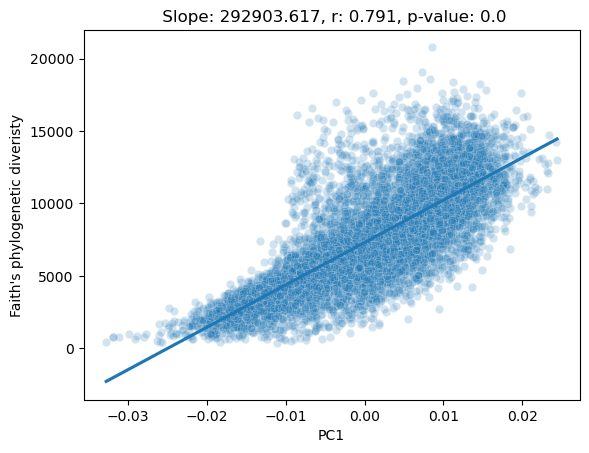

In [67]:
subset_ = meta_phyloRPCA_ord.loc[~meta_phyloRPCA_ord['faiths_pd'].isnull()]
sns.regplot(x='0' ,y='faiths_pd',data=subset_,scatter=False)
sns.scatterplot(x='0' ,y='faiths_pd',data=subset_,alpha=0.2)

res = stats.linregress(subset_['0'],
                       subset_['faiths_pd'])
plt.title(f" Slope: {res.slope:.3f}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
plt.xlabel('PC1')
plt.ylabel('Faith\'s phylogenetic diveristy')


In [68]:
for group in meta_phyloRPCA_ord['test_column'].unique():
    median = meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group,'faiths_pd'].median()
    meta_phyloRPCA_ord.loc[meta_phyloRPCA_ord['test_column']==group,str(str('faiths_pd')+'_median')]=median

Text(0, 0.5, "Faith's Phylogenetic Diversity")

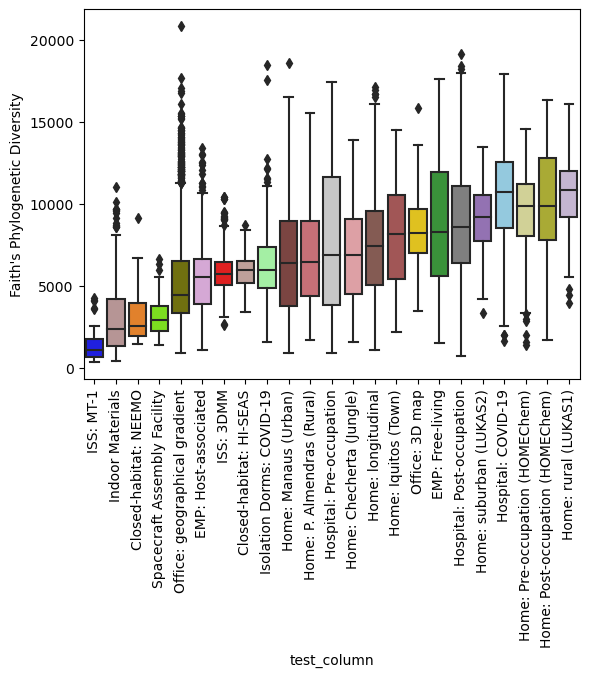

In [69]:
sns.boxplot(x='test_column',y='faiths_pd',
            data=meta_phyloRPCA_ord.loc[(meta_phyloRPCA_ord['env_package']=='built environment')|
                                        (meta_phyloRPCA_ord['test_column'].isin(['EMP: Free-living','EMP: Host-associated']))].sort_values(by='faiths_pd_median'),
           palette=meta_colors)
plt.xticks(rotation=90)
plt.ylabel('Faith\'s Phylogenetic Diversity')

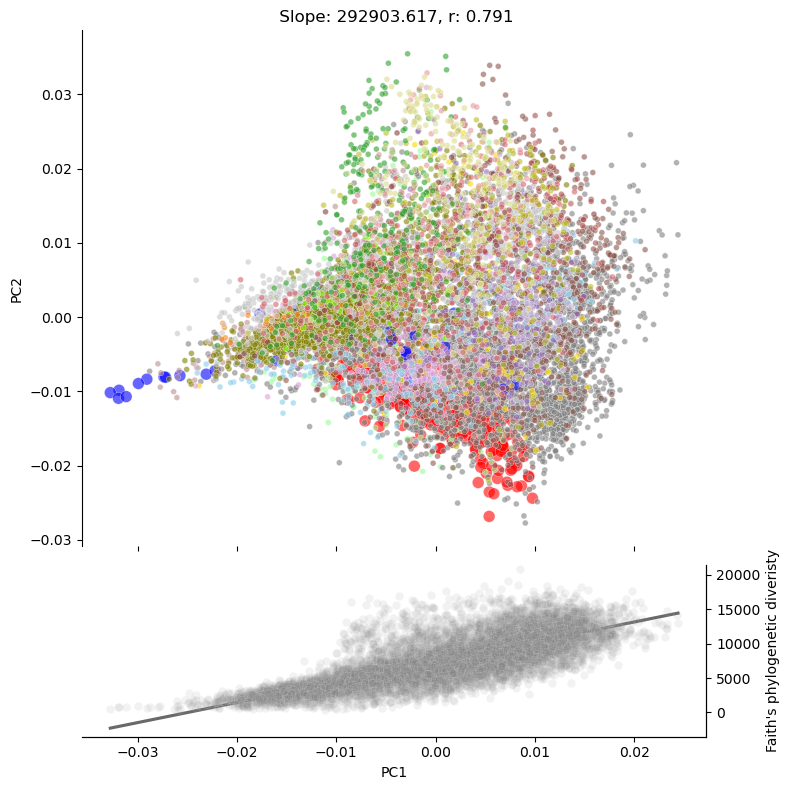

In [70]:
# Fig 5A, bottom panel
# Fig 5A was arranged with Illustrator for final figure.
f, (ax1,ax2) =plt.subplots(nrows=2,figsize=(8,8),gridspec_kw={'height_ratios': [3, 1]},sharex=True)
sns.scatterplot(x=0,y=1,hue='test_column',data=meta_phyloRPCA_ord.sort_values(by='1_median'),ax=ax1,alpha=0.6,
                size='sizes_plot',hue_order=meta_colors.keys(),palette=meta_colors)

subset_ = meta_phyloRPCA_ord.loc[~meta_phyloRPCA_ord['faiths_pd'].isnull()]
ax3 = ax2.twinx()
sns.scatterplot(x='0' ,y='faiths_pd',data=subset_,alpha=0.1,ax=ax3,color='gray')
sns.regplot(x='0' ,y='faiths_pd',data=subset_,scatter=False,ax=ax2,color='dimgray')
ax2.set_ylim(-3541.695380464418, 21502.14411359359)
ax2.spines[['left', 'top']].set_visible(False)
ax3.spines[['left', 'top']].set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.set_ylim(-3541.695380464418, 21502.14411359359)
res = stats.linregress(subset_['0'],
                       subset_['faiths_pd'])

ax1.set_title(f" Slope: {res.slope:.3f}, r: {res.rvalue:.3f}")
ax2.set_xlabel('PC1')
ax3.set_ylabel('Faith\'s phylogenetic diveristy')
ax1.spines[['bottom','right', 'top']].set_visible(False)
ax2.spines[['left', 'top']].set_visible(False)
ax1.get_legend().remove()
plt.tight_layout()
ax1.set_ylabel('PC2')
plt.xlabel('PC1')
plt.savefig('./figs/meta_analysis_fig_alpha.png',dpi=600)

In [71]:
# Tree coverage calculations with 20 trials

In [72]:
total_tree_length = sum([n.length for n in meta_phyloRPCA_cbnt.view(TreeNode).traverse(include_self=False)])

In [73]:
total_tree_length

436862.80819800706

In [74]:
from qiime2.plugins.feature_table.methods import group
from qiime2.plugins.feature_table.methods import subsample

In [75]:
meta_metadata_df_f = meta_metadata_df.copy()
meta_metadata_df_f['date'] = meta_metadata_df_f['date'].astype(str)

In [76]:
meta_ft_grouped = group(meta_ft,axis='sample',metadata=Metadata(meta_metadata_df_f).get_column('test_column'),mode='sum')
meta_ft_grouped = meta_ft_grouped.grouped_table
grouped_md = pd.DataFrame(index=meta_ft_grouped.view(pd.DataFrame).index)
for env_ in grouped_md.index:
    for md_column in ['qiita_study_id','test_column']:
        grouped_md.loc[env_,md_column] = meta_metadata_df_f.loc[meta_metadata_df_f['test_column']==env_,md_column].unique()
grouped_md.index.names=['sample_name']
grouped_md['collapse_column']='full_merged_data'

In [77]:
# Takes some time to run

# #Sub-study with smallest sample size is n=32
# subsample_n = 32
# trial_df = pd.DataFrame()
# for trial in range(20):
#     merged = pd.DataFrame()
#     for env_ in grouped_md.index:
#         env_partition = filter_samples(meta_ft,metadata=Metadata(meta_metadata_df_f),where=f"test_column =='{env_}'").filtered_table
#         if env_ not in ['EMP: Host-associated','EMP: Free-living']:
#             env_partition = filter_samples(env_partition,metadata=Metadata(meta_metadata_df_f),where="env_package=='built environment'").filtered_table
#         env_part_sub = subsample(env_partition,subsample_n,axis='sample').sampled_table
#         env_part_sub_colapsed = group(env_part_sub,metadata=Metadata(meta_metadata_df_f).get_column('test_column'),axis='sample',mode='sum').grouped_table
#         env_part_sub_df = env_part_sub_colapsed.view(pd.DataFrame)
#         merged = pd.concat([merged,env_part_sub_df],sort=True)
#     merged = merged.fillna(0)
#     rarefaction_depth = int(merged.sum(axis=1).min())
#     merged_artifact = Artifact.import_data('FeatureTable[Frequency]', merged)
#     merged_artifact_alpha = alpha_phylogenetic(merged_artifact,meta_phyloRPCA_cbnt,metric='faith_pd').alpha_diversity.view(pd.Series)
#     trial_ = pd.DataFrame(merged_artifact_alpha)
#     trial_['trial']=trial
    
#     trial_df = pd.concat([trial_df,pd.DataFrame(merged_artifact_alpha)])
    
# trial_df.to_csv('./output/meta_phylogenetic_tree_coverage.csv')

In [78]:
#loading from file
trial_df = pd.read_csv('./output/meta_phylogenetic_tree_coverage.csv',index_col='Unnamed: 0')
trial_df.reset_index(inplace=True)

Text(0.5, 0, 'Environment')

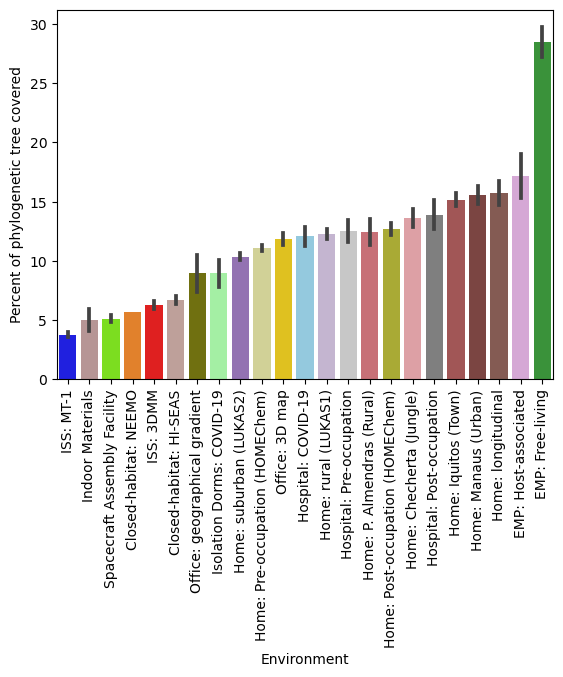

In [79]:
trial_df['alpha_perc'] = (trial_df['faith_pd']/total_tree_length)*100
for env_ in trial_df['index'].unique():
    trial_df.loc[trial_df['index']==env_,'alpha_perc_median'] = trial_df.loc[trial_df['index']==env_,'alpha_perc'].median()

    
sns.barplot(x='index',y='alpha_perc',data=trial_df.sort_values(by='alpha_perc_median'),errorbar='sd',palette=meta_colors)
plt.xticks(rotation=90)
plt.ylabel('Percent of phylogenetic tree covered')
plt.xlabel('Environment')

# Multi-study analysis robustness

In [80]:
# Ran meta_robustness_high.py & meta_robustness_low.py in computer cluster

In [81]:
meta_beta_robust_low_prev = pd.read_csv('./output/meta_beta_robustness_low_prevalence.csv')
meta_beta_robust = pd.read_csv('./output/meta_beta_robustness.csv')

In [83]:
meta_beta_robust_df = pd.concat([meta_beta_robust,meta_beta_robust_low_prev])

/Users/rsalidob/miniconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


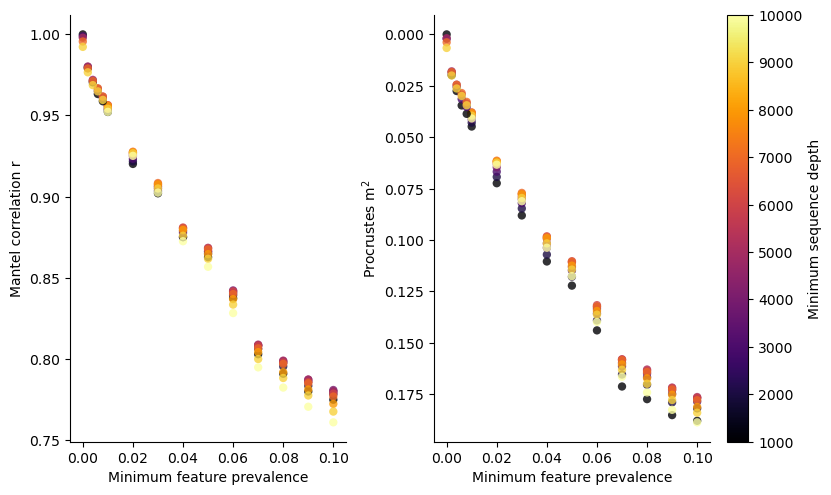

In [84]:
f, (ax1,ax2)=plt.subplots(ncols=2,figsize=(8,5),gridspec_kw={'width_ratios':[0.8,1]})
sns.scatterplot(x='prev',y='mantel_r',hue='depth',data=meta_beta_robust_df,palette='inferno',ax=ax1,legend=None,alpha=0.8,linewidth=0)
sns.scatterplot(x='prev',y='procrustes_m2',hue='depth',data=meta_beta_robust_df,palette='inferno',ax=ax2,legend=None,alpha=0.8,linewidth=0,
               cmap='magma')
ax2.invert_yaxis()
plt.tight_layout()
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

ax1.set_xlabel('Minimum feature prevalence')
ax2.set_xlabel('Minimum feature prevalence')

ax1.set_ylabel('Mantel correlation r')
ax2.set_ylabel('Procrustes $\mathregular{m^{2}}$')
norm= matplotlib.colors.Normalize(vmin=meta_beta_robust_df['depth'].min(),
                                  vmax=meta_beta_robust_df['depth'].max())
cb = plt.cm.ScalarMappable(norm=norm,cmap='inferno')
cbar = f.colorbar(cb,ax=ax2,label='Minimum sequence depth')
plt.savefig('./figs/meta_beta_robustness.svg')